Use two RNN models (one with simple vanilla RNN cells, other with GRU cells) to predict the temperature 1 hour into the future given the past 12 hours:

https://keras.io/api/layers/recurrent_layers/simple_rnn/

https://keras.io/api/layers/recurrent_layers/gru/

- In this task you're required to split the data into training, validation and test. [2 points]
-Use the test set to test the generalization error of your models.[3 points each] 
- Use mean absolute error as an evaluation metric [1 point]
- Compare the performance of the two models and comment on the results [1 points]
- At least one of them MUST contain more than a single RNN layer; {Hint: check return_sequence parameter in the RNN layers documentation to help you in that.}
##Bonus[2 point]
- Predict the test set, and plot a predicted 500-1000 labels vs. the actual labels.

# import 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile

In [ ]:
#get the dataset
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

# preproccesing

In [ ]:
df = pd.read_csv(csv_path)
df=df.drop(columns=['Date Time','Tpot (K)','Tdew (degC)','wd (deg)','max. wv (m/s)'])
df.describe()

,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224
std,8.358481,8.423365,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714
min,913.600000,-23.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000
25%,984.200000,3.360000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000
50%,989.580000,9.420000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000
75%,994.720000,15.470000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000
max,1015.350000,37.280000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000


In [ ]:
change_rows= (df['wv (m/s)']<0)
df['wv (m/s)'][change_rows]=0
df.describe()

,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,2.130191
std,8.358481,8.423365,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,1.542334
min,913.600000,-23.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000
25%,984.200000,3.360000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000
50%,989.580000,9.420000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000
75%,994.720000,15.470000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000
max,1015.350000,37.280000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000


# prameters

In [ ]:
step=6
start=12*6+step
sequence_length=12
length=420000
batch_size = 256
learning_rate=0.001
epochs=10
data=df.values

# important functions

In [ ]:
#return the normalized values for 3 arrays(train, validation and test) of data
def normalize(data,start,length ,train_ratio,val_ratio):

  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  normalized=(data - data_mean) / data_std

  normalized_data=normalized[0:length]
  labels=normalized[start:start+length,1]

  train_split=int(train_ratio*length)
  val_split=int(val_ratio*length)

  train=normalized_data[:train_split]
  val=normalized_data[train_split:val_split+train_split]
  test=normalized_data[val_split+train_split:]

  train_labels=labels[:train_split]
  val_labels=labels[train_split:val_split+train_split]
  test_labels=labels[val_split+train_split:]

  return train,val,test,train_labels,val_labels,test_labels

In [ ]:
def plot_test(dataset_test,model):
  for x,y in dataset_test.take(1):
    predected=model.predict(x)
    time_steps = list(range(y.numpy().shape[0]))
    labels=["actual","predected"]
    score = model.evaluate(x, y, verbose = 0) 
    print('loss:', score[0],'   mean absluote error:' , score[1],'   mean square error:' , score[2])
    plt.plot(time_steps, y,label=labels[0])
    plt.plot(time_steps, predected,label=labels[1])
    plt.show()


# prepare data for models

In [ ]:
train,val,test,train_labels,val_labels,test_labels=normalize(data,start,length ,0.6,0.2)

In [ ]:
dataset_train=tf.keras.preprocessing.timeseries_dataset_from_array(
    train,
    train_labels,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size
)

In [ ]:
dataset_val=tf.keras.preprocessing.timeseries_dataset_from_array(
    val,
    val_labels,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size
)

In [ ]:
length_test=1000
dataset_test=tf.keras.preprocessing.timeseries_dataset_from_array(
    train,
    train_labels,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=length_test
)

# models 

In [ ]:
inputs = keras.layers.Input(shape=(sequence_length,train.shape[1]))
lstm_out1 = keras.layers.LSTM(32,return_sequences=True)(inputs)
lstm_out2 = keras.layers.LSTM(32,return_sequences=True)(lstm_out1)
lstm_out3 = keras.layers.LSTM(32)(lstm_out2)
outputs = keras.layers.Dense(1)(lstm_out3)
model1 = keras.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae",metrics=[tf.keras.metrics.mean_absolute_error,tf.keras.metrics.mean_squared_error])
model1.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 12, 10)]          0         
                                                                 
 lstm_22 (LSTM)              (None, 12, 32)            5504      
                                                                 
 lstm_23 (LSTM)              (None, 12, 32)            8320      
                                                                 
 lstm_24 (LSTM)              (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22,177
Trainable params: 22,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model1.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val
)

Epoch 1/10
985/985 [==============================] - 52s 46ms/step - loss: 0.3132 - mean_absolute_error: 0.3132 - mean_squared_error: 0.1897 - val_loss: 0.2955 - val_mean_absolute_error: 0.2955 - val_mean_squared_error: 0.1351
Epoch 2/10
985/985 [==============================] - 46s 46ms/step - loss: 0.1690 - mean_absolute_error: 0.1690 - mean_squared_error: 0.0586 - val_loss: 0.1543 - val_mean_absolute_error: 0.1543 - val_mean_squared_error: 0.0409
Epoch 3/10
985/985 [==============================] - 46s 47ms/step - loss: 0.1303 - mean_absolute_error: 0.1303 - mean_squared_error: 0.0324 - val_loss: 0.1442 - val_mean_absolute_error: 0.1442 - val_mean_squared_error: 0.0358
Epoch 4/10
985/985 [==============================] - 45s 45ms/step - loss: 0.1225 - mean_absolute_error: 0.1225 - mean_squared_error: 0.0290 - val_loss: 0.1428 - val_mean_absolute_error: 0.1428 - val_mean_squared_error: 0.0343
Epoch 5/10
985/985 [==============================] - 45s 46ms/step - loss: 0.1176 - mea

32/32 [==============================] - 0s 3ms/step
loss: 0.3244974911212921    mean absluote error: 0.3244974911212921    mean square error: 0.1626584380865097


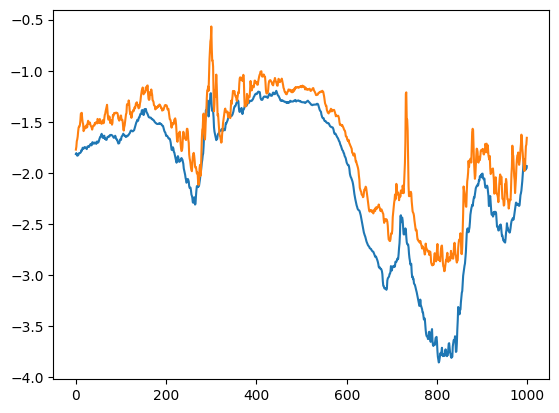

In [ ]:
plot_test(dataset_test,model1)

In [ ]:
inputs = keras.layers.Input(shape=(sequence_length,train.shape[1]))
gru_out1 = keras.layers.GRU(32,return_sequences=True)(inputs)
gru_out2 = keras.layers.GRU(32,return_sequences=True)(gru_out1)
gru_out3 = keras.layers.GRU(32)(gru_out2)
outputs = keras.layers.Dense(1)(gru_out3)

model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae",metrics=[tf.keras.metrics.mean_absolute_error,tf.keras.metrics.mean_squared_error])
model2.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 12, 10)]          0         
                                                                 
 gru_6 (GRU)                 (None, 12, 32)            4224      
                                                                 
 gru_7 (GRU)                 (None, 12, 32)            6336      
                                                                 
 gru_8 (GRU)                 (None, 32)                6336      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 16,929
Trainable params: 16,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val
)

Epoch 1/10
985/985 [==============================] - 50s 46ms/step - loss: 0.2107 - mean_absolute_error: 0.2107 - mean_squared_error: 0.0928 - val_loss: 0.1705 - val_mean_absolute_error: 0.1705 - val_mean_squared_error: 0.0478
Epoch 2/10
985/985 [==============================] - 43s 44ms/step - loss: 0.1413 - mean_absolute_error: 0.1413 - mean_squared_error: 0.0386 - val_loss: 0.1295 - val_mean_absolute_error: 0.1295 - val_mean_squared_error: 0.0305
Epoch 3/10
985/985 [==============================] - 44s 45ms/step - loss: 0.1281 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0314 - val_loss: 0.1340 - val_mean_absolute_error: 0.1340 - val_mean_squared_error: 0.0313
Epoch 4/10
985/985 [==============================] - 43s 43ms/step - loss: 0.1226 - mean_absolute_error: 0.1226 - mean_squared_error: 0.0291 - val_loss: 0.1269 - val_mean_absolute_error: 0.1269 - val_mean_squared_error: 0.0287
Epoch 5/10
985/985 [==============================] - 44s 44ms/step - loss: 0.1188 - mea

32/32 [==============================] - 0s 3ms/step
loss: 0.25538957118988037    mean absluote error: 0.25538957118988037    mean square error: 0.12161597609519958


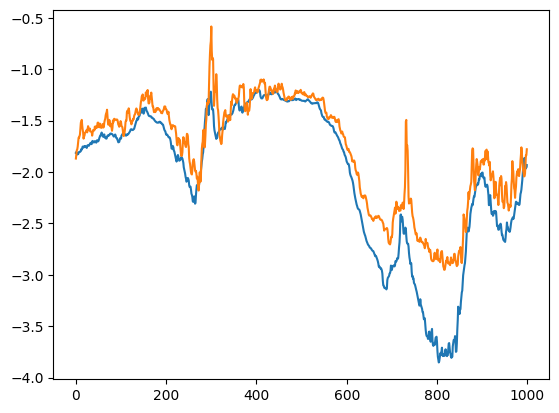

In [ ]:
plot_test(dataset_test,model2)

In [ ]:
inputs = keras.layers.Input(shape=(sequence_length,train.shape[1]))
RNN_out1 = keras.layers.SimpleRNN(32,return_sequences=True)(inputs)
RNN_out2 = keras.layers.SimpleRNN(32,return_sequences=True)(RNN_out1)
RNN_out3 = keras.layers.SimpleRNN(32)(RNN_out2)
outputs = keras.layers.Dense(1)(RNN_out3)

model3 = keras.Model(inputs=inputs, outputs=outputs)
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae",metrics=[tf.keras.metrics.mean_absolute_error,tf.keras.metrics.mean_squared_error])
model3.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 12, 10)]          0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 12, 32)            1376      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 12, 32)            2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model3.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val
)

Epoch 1/10
985/985 [==============================] - 76s 74ms/step - loss: 0.2399 - mean_absolute_error: 0.2399 - mean_squared_error: 0.1141 - val_loss: 0.1681 - val_mean_absolute_error: 0.1681 - val_mean_squared_error: 0.0478
Epoch 2/10
985/985 [==============================] - 72s 73ms/step - loss: 0.1708 - mean_absolute_error: 0.1708 - mean_squared_error: 0.0537 - val_loss: 0.1491 - val_mean_absolute_error: 0.1491 - val_mean_squared_error: 0.0386
Epoch 3/10
985/985 [==============================] - 75s 76ms/step - loss: 0.1488 - mean_absolute_error: 0.1488 - mean_squared_error: 0.0403 - val_loss: 0.1290 - val_mean_absolute_error: 0.1290 - val_mean_squared_error: 0.0295
Epoch 4/10
985/985 [==============================] - 75s 77ms/step - loss: 0.1373 - mean_absolute_error: 0.1373 - mean_squared_error: 0.0347 - val_loss: 0.1190 - val_mean_absolute_error: 0.1190 - val_mean_squared_error: 0.0264
Epoch 5/10
985/985 [==============================] - 76s 77ms/step - loss: 0.1315 - mea

32/32 [==============================] - 0s 11ms/step
loss: 0.2594945728778839    mean absluote error: 0.2594945728778839    mean square error: 0.11187565326690674


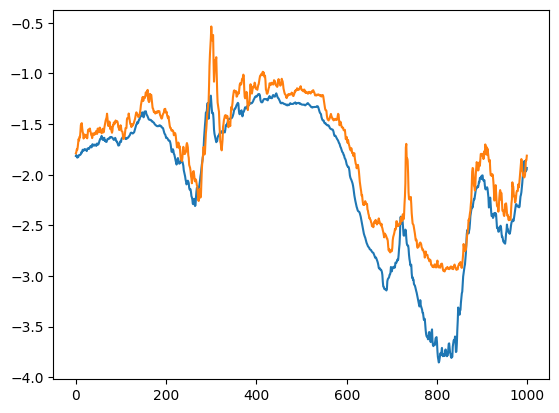

In [ ]:
plot_test(dataset_test,model3)

# Comment
LSTM: loss:  0.324   mean absluote error: 0.324   mean square error: 0.162

GRU: loss:   0.255   mean absluote error: 0.255   mean square error: 0.121

RNN: loss:   0.259   mean absluote error: 0.259   mean square error: 0.111

the best model is the GRU model and then the RNN and the worest is the LSTM 
## note: all models have the same build and the same parameters  
